In [1]:
import re

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Stations ids

In [89]:
stations = (pd.read_csv('stations.csv')
              .loc[:,'id'])

## Bikes data

In [4]:
def duration_to_minutes(value):
    value = value[:-3].replace(' ', '')
    value = re.split(r'[a-z]+', value, flags=re.IGNORECASE)
    value = (int(value[0]) * 60 + int(value[1]))
    return value

In [5]:
data = (pd.read_csv('bikes-raw-2017.csv')
          .loc[:,['fecha_hora_retiro', 'origen_estacion', 'destino_estacion', 'tiempo_uso']]
          .rename(columns={'fecha_hora_retiro':'timestamp', 'origen_estacion':'comes',
                           'destino_estacion':'goes', 'tiempo_uso':'duration'})
          .assign(timestamp = lambda df: pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M:%S'), 
                  duration = lambda df: df['duration'].apply(lambda x: duration_to_minutes(x)).astype(int),
                  comes = lambda df: df['comes'].astype(int), goes = lambda df: df['goes'].astype(int))
)

Extract weekdays

In [6]:
data = data.loc[data['timestamp'].dt.weekday < 5]

### Number of days

In [53]:
days = data.timestamp.dt.date.nunique()
[days]

[168]

### Number of hours

In [55]:
hours = (data.assign(date = data.timestamp.dt.date, hour = data.timestamp.dt.hour, rec = 1)
             .groupby(['date','hour']).size().to_frame('count').reset_index()
             .groupby('hour').size().tolist())
hours[0:12]

[167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167]

### Daily use

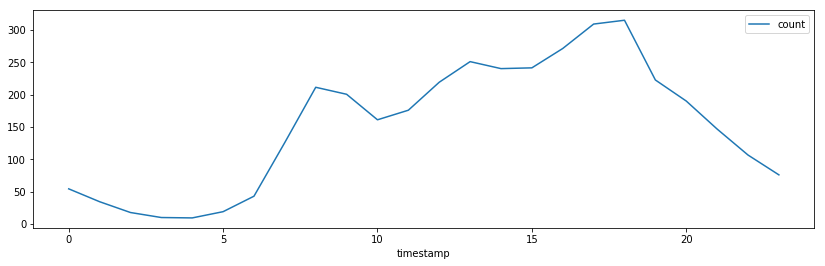

In [325]:
daily = (data.groupby(data.timestamp.dt.hour).size() / 168).to_frame('count')
daily.plot(figsize=(14,4))

In [327]:
#daily = (daily / daily.sum())['count'].apply(lambda x: round(x, 4)).tolist()
daily

[0.0149,
 0.0094,
 0.0048,
 0.0027,
 0.0025,
 0.0052,
 0.0117,
 0.0345,
 0.0579,
 0.0549,
 0.0441,
 0.0482,
 0.06,
 0.0687,
 0.0658,
 0.0661,
 0.0743,
 0.0847,
 0.0863,
 0.061,
 0.0521,
 0.0402,
 0.0292,
 0.0208]

### Mean daily trips

In [7]:
mean_daily_trips = data.groupby(data.timestamp.dt.date).size().mean()
strd_daily_trips = data.groupby(data.timestamp.dt.date).size().std()
print(round(mean_daily_trips), '±', round(strd_daily_trips))

5090 ± 1755


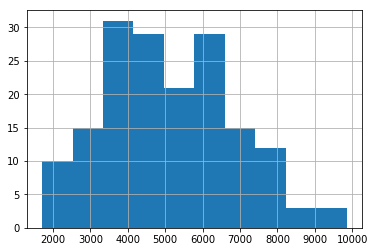

In [9]:
data.groupby(data.timestamp.dt.date).size().hist()

### Stations use per day

In [32]:
data = (data.loc[(data['comes'].isin(stations)) & (data['goes'].isin(stations))]
            .reset_index(drop=True))

In [90]:
station_data = (
    (data.groupby(data.comes).size()/days)
    .to_frame('departures').reset_index().rename(columns={'comes':'station'})
).merge(on='station', how='left', right=
(
    (data.groupby(data.goes).size()/days)
    .to_frame('arrivals').reset_index().rename(columns={'goes':'station'})
)).sort_values(['departures','arrivals'], ascending=False).reset_index(drop=True)

In [91]:
station_data = station_data.assign(movements = lambda df: df['departures'] + df['arrivals'],
                                   market = lambda df: df['movements']/(mean_daily_trips*2))

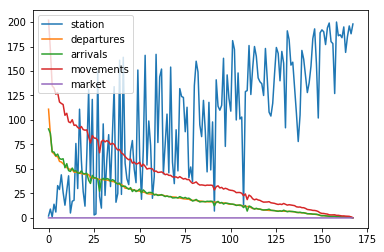

In [68]:
station_data.plot()

### Number of active days (known active days)

In [92]:
station_data = station_data.merge(right = (
    data.assign(date = lambda df: df.timestamp.dt.date)
        .groupby(['comes']).agg({'date':'nunique'})
        .reset_index()
        .rename(columns={'comes':'station','date':'kad'})
), on='station', how='left')

### Survival time

In [189]:
temp = pd.DataFrame(columns=['station', 'survival'])

for i,x in enumerate(stations.drop(9, axis=0)):
    if (data.loc[data['comes'] == x].size == 0 | data.loc[data['goes'] == x].size == 0):
        continue
    temp.loc[i,'station'] = x
    temp.loc[i,'survival'] = (pd.concat([(
        data.loc[data['comes']==x]
            .reset_index(drop=True)
            .loc[:, 'timestamp']
    ),(
        data.loc[data['goes']==x]
            .assign(duration = lambda df: df['duration'].apply(lambda z: np.timedelta64(z, 'm')),
                    timestamp= lambda df: df['timestamp'] + df['duration'])
            .loc[:,'timestamp'].reset_index(drop=True)
    )]).reset_index(drop=True).to_frame('event').sort_values('event')
       .assign(duration = lambda df: (df['event'].shift(-1) - df['event']) / np.timedelta64(1, 'm'))
       .duration.median()
    )
    
temp['station'] = temp['station'].astype(int)
temp['survival'] = temp['survival'].apply(lambda x: round(x)).astype(int)
station_data = station_data.merge(temp, on='station', how='left')

### Top five comes per hour

In [155]:
top_five = pd.DataFrame()

for x in range(0,24):
    
    _ = (data.loc[data.timestamp.dt.hour == x]
             .groupby('comes').size().to_frame('departures')
             .reset_index()
             .rename(columns = {'comes':'station'})
             .merge(station_data[['station', 'kad']], on='station', how='left')
             .assign(daily_departures = lambda df: df['departures']/df['kad'],
                     market = lambda df: df['daily_departures']/df['daily_departures'].sum(),
                     hour = x)
             .sort_values(['hour', 'market'], ascending=[True, False])
             .reset_index(drop=True)
             .loc[0:4]
             .assign(divide = lambda df: df['market']/df['market'].sum(),
                     selector = lambda df: (df['market']/df['market'].sum()).cumsum()))
    top_five = pd.concat([top_five, _], ignore_index=True)

In [254]:
len(top_five)

120

In [253]:
top_five.head()

,station,departures,kad,daily_departures,market,hour,divide,selector
0,9,304,164,1.853659,0.025322,0,0.232181,0.232181
1,14,271,156,1.737179,0.023731,0,0.217591,0.449772
2,167,167,111,1.504505,0.020552,0,0.188447,0.638220
3,30,232,155,1.496774,0.020447,0,0.187479,0.825699
4,29,231,166,1.391566,0.019010,0,0.174301,1.000000


### Top five comes to json

In [117]:
import json

In [157]:
main_data = {}

for x in range(0,24):
    jnot = top_five.loc[top_five['hour'] == x, ['station', 'divide', 'selector']].to_json(orient='records')
    jyes = json.loads(jnot)
    main_data[x] = jyes

In [ ]:
main_data

### Top five goes

In [281]:
goes_frame = pd.DataFrame()

for h in range(0,24):
    for s in top_five.loc[top_five['hour'] == h].station:
        _ = (data.loc[(data.comes==s)&(data.timestamp.dt.hour==h)]
                 .groupby(['goes']).size().to_frame('count').reset_index()
                 .sort_values(['count'], ascending=[False]).reset_index()
                 .loc[0:4]
                 .assign(divide = lambda df: df['count']/df['count'].sum(),
                         selector = lambda df: df['divide'].cumsum(),
                         hour = h,
                         comes = s)
                 .rename(columns={'goes':'station'}))
        goes_frame = pd.concat([goes_frame, _], ignore_index=True)
goes_frame = goes_frame.drop('index', axis=1)

In [286]:
goes_frame.head()

,station,count,divide,selector,hour,comes
0,9,31,0.340659,0.340659,0,9
1,30,21,0.230769,0.571429,0,9
2,56,14,0.153846,0.725275,0,9
3,65,14,0.153846,0.879121,0,9
4,85,11,0.120879,1.000000,0,9


In [290]:
mean_duration = []
sd_duration = []
for i, row in goes_frame.iterrows():
    h = int(row['hour'])
    c = int(row['comes'])
    g = int(row['station'])
    mean_duration.append(data.loc[(data.timestamp.dt.hour.astype(int) == h)
                                  &(data['comes'].astype(int) == c)
                                  &(data['goes'].astype(int) == g)]
                             .duration.mean())
    sd_duration.append(data.loc[(data.timestamp.dt.hour.astype(int) == h)
                                  &(data['comes'].astype(int) == c)
                                  &(data['goes'].astype(int) == g)]
                             .duration.std())

In [295]:
goes_frame[['duration_mean','duration_sd']] = goes_frame[['duration_mean','duration_sd']].apply(lambda x: round(x,2))

599

In [317]:
mask = ['station','divide','selector', 'duration_mean','duration_sd']

In [323]:
major_data = {}

for h in range(0,24):
    minor_data = {}
    for s in top_five.loc[top_five['hour'] == h].station:
        _ = goes_frame.loc[(goes_frame.hour == h)&(goes_frame.comes == s)]
        minor = json.loads(_[mask].to_json(orient='records'))
        
        minor_data[int(s)] = minor
    major_data[h] = minor_data

In [319]:
with open('goesData.json', 'w') as outfile:
    json.dump(major_data, outfile)

In [324]:
major_data

{0: {9: [{'station': 9.0,
    'divide': 0.3406593407,
    'selector': 0.3406593407,
    'duration_mean': 55.84,
    'duration_sd': 33.58},
   {'station': 30.0,
    'divide': 0.2307692308,
    'selector': 0.5714285714,
    'duration_mean': 47.38,
    'duration_sd': 25.23},
   {'station': 56.0,
    'divide': 0.1538461538,
    'selector': 0.7252747253,
    'duration_mean': 13.71,
    'duration_sd': 5.78},
   {'station': 65.0,
    'divide': 0.1538461538,
    'selector': 0.8791208791,
    'duration_mean': 57.29,
    'duration_sd': 19.92},
   {'station': 85.0,
    'divide': 0.1208791209,
    'selector': 1.0,
    'duration_mean': 54.45,
    'duration_sd': 27.26}],
  14: [{'station': 14.0,
    'divide': 0.2673267327,
    'selector': 0.2673267327,
    'duration_mean': 48.67,
    'duration_sd': 22.71},
   {'station': 44.0,
    'divide': 0.2376237624,
    'selector': 0.504950495,
    'duration_mean': 41.58,
    'duration_sd': 25.35},
   {'station': 5.0,
    'divide': 0.2277227723,
    'selector':